## MOVIE RECOMMENDER SYSTEMS

### Overview

The MovieLens Beliefs Dataset expands on standard movie ratings and recommendations by including users' stated expectations ("beliefs") about movies they haven't seen. Collected between March 2023 and May 2024 from users who responded to a specific MovieLens homepage feature, the dataset comprises movie information, user rating history, the set of movies used for belief elicitation, user recommendation history, and the core belief data (predicted ratings, certainty, etc.).The goal is to provide researchers with rich pre-consumption data to better understand user behavior and improve recommender systems.

### Objectives

- Understand how users form beliefs about movies they haven't seen.

- Investigate the relationship between user beliefs, past ratings, and received recommendations.

- Evaluate how well recommendation systems align with and influence user beliefs.

- Study user decision-making processes in the context of movie consumption.



### Business Questions

- How do users form beliefs or expectations about movies they haven’t watched yet?

- What factors (e.g., genres, tags, ratings, recommendations) most influence these beliefs?

- How closely do user beliefs align with their actual ratings after watching a movie?

- How do past user ratings and behaviors affect the relevance of future recommendations?

- To what extent do recommendations influence or shape user expectations and decisions?

### Data Understanding

The data used in this project will be pulled from 4 different separate file:

1.Movies Data (movies.csv):

Contains movie information, including titles and genres.
movieId: Unique identifier for each movie.
title: The title of the movie, which also includes the year of release in parentheses.
genres: A pipe-separated list of genres to categorize the movie (e.g., Action|Adventure|Comedy).

2.Links Data (links.csv):

Provides identifiers for linking to external movie-related sources (IMDb, TMDb).
movieId: Unique identifier for each movie, consistent with other data files.
imdbId: Identifier for movies used by IMDb (Internet Movie Database).
tmdbId: Identifier for movies used by TMDb (The Movie Database).

3.Ratings Data (ratings.csv):

Each entry represents a user's rating for a specific movie.
Contains user ratings on a 5-star scale for movies.
userId: ID representing the unique identifier for each user.
movieId: Unique identifier for each movie.
rating: User's rating for the movie on a 5-star scale with half-star increments (0.5 to 5.0).
timestamp: The timestamp when the rating was recorded, represented in seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

4.Tags Data (tags.csv):

Contains user-generated metadata (tags) about movies.
userId: ID representing the unique identifier for each user.
movieId: Unique identifier for each movie.
tag: User-generated metadata describing a movie, typically a single word or short phrase.
timestamp: The timestamp when the tag was applied, represented in seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [118]:
#importing the neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV, cross_validate


In [119]:
#loading the datasets
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [120]:
#checking the first few rows of the movies dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [121]:
#checking the first few rows of the links dataset
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [122]:
#checking the first few rows of the ratings dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [123]:
#checking the first few rows of the tags dataset
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [124]:
#merging datasets
df = movies.merge(ratings, on='movieId', how='left').merge(tags, on=['movieId', 'userId'], how='left',
    suffixes=('_rating', '_tag')).merge(links,on='movieId',how='left')

In [125]:
#Checking the number of rows and columns
df.shape

(102695, 10)

In [126]:
#checking the first few rows of the merged dataset
df.head()

,movieId,title,genres,userId,rating,timestamp_rating,tag,timestamp_tag,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,NaN,NaN,114709,862.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,NaN,NaN,114709,862.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,NaN,NaN,114709,862.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,NaN,NaN,114709,862.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,NaN,NaN,114709,862.0


In [127]:
#checking the column titles
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp_rating',
       'tag', 'timestamp_tag', 'imdbId', 'tmdbId'],
      dtype='object')

### Data Cleaning

#### Handling missing values

In [128]:
#checking missing values
df.isnull().sum()

movieId                 0
title                   0
genres                  0
userId                 18
rating                 18
timestamp_rating       18
tag                 99219
timestamp_tag       99219
imdbId                  0
tmdbId                 13
dtype: int64

In [129]:
#percentage of null values
null_percent = (df.isnull().sum() / len(df)) * 100
print(null_percent)

movieId              0.000000
title                0.000000
genres               0.000000
userId               0.017528
rating               0.017528
timestamp_rating     0.017528
tag                 96.615220
timestamp_tag       96.615220
imdbId               0.000000
tmdbId               0.012659
dtype: float64


In [130]:
#replacing missing value for 'timestamp_tag'and'tag'
df['timestamp_tag'].fillna(df['timestamp_tag'].mean(), inplace=True)
df['tag'].fillna('unknown', inplace=True)


In [131]:
#dropping missing values'userId','userId','rating','timestamp_rating'and'tmdbId'
df.dropna(subset= ['userId','userId','rating','timestamp_rating','tmdbId'],inplace=True)

In [132]:
 
time_filtered_df = df[df['timestamp_rating'].notnull() & df['timestamp_tag'].notnull()]

In [133]:
# Checking if there are still missing values in the cleaned dataset
df.isnull().sum()

movieId             0
title               0
genres              0
userId              0
rating              0
timestamp_rating    0
tag                 0
timestamp_tag       0
imdbId              0
tmdbId              0
dtype: int64

Handling duplicates

In [134]:
#checking duplicates
df.duplicated().sum()

0

In [135]:
#checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102664 entries, 0 to 102694
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieId           102664 non-null  int64  
 1   title             102664 non-null  object 
 2   genres            102664 non-null  object 
 3   userId            102664 non-null  float64
 4   rating            102664 non-null  float64
 5   timestamp_rating  102664 non-null  float64
 6   tag               102664 non-null  object 
 7   timestamp_tag     102664 non-null  float64
 8   imdbId            102664 non-null  int64  
 9   tmdbId            102664 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 8.6+ MB


In [136]:
# Converting user IDs and tmdbId to object data type
df[['userId', 'tmdbId']] = df[['userId', 'tmdbId']].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102664 entries, 0 to 102694
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieId           102664 non-null  int64  
 1   title             102664 non-null  object 
 2   genres            102664 non-null  object 
 3   userId            102664 non-null  object 
 4   rating            102664 non-null  float64
 5   timestamp_rating  102664 non-null  float64
 6   tag               102664 non-null  object 
 7   timestamp_tag     102664 non-null  float64
 8   imdbId            102664 non-null  int64  
 9   tmdbId            102664 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 8.6+ MB


### Exploratory Data Analysis (EDA) 

##### Rating Distribution

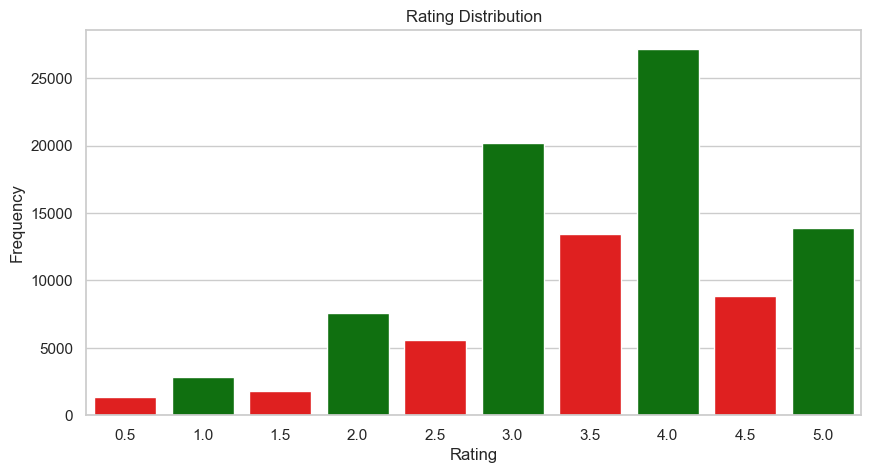

In [137]:
#Rating Distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.countplot(x=df['rating'], palette=['red','green'])
plt.title("Rating Distribution")
plt.xlabel('Rating')
plt.ylabel("Frequency")
plt.show()


##### Rating Distribution by Genre 

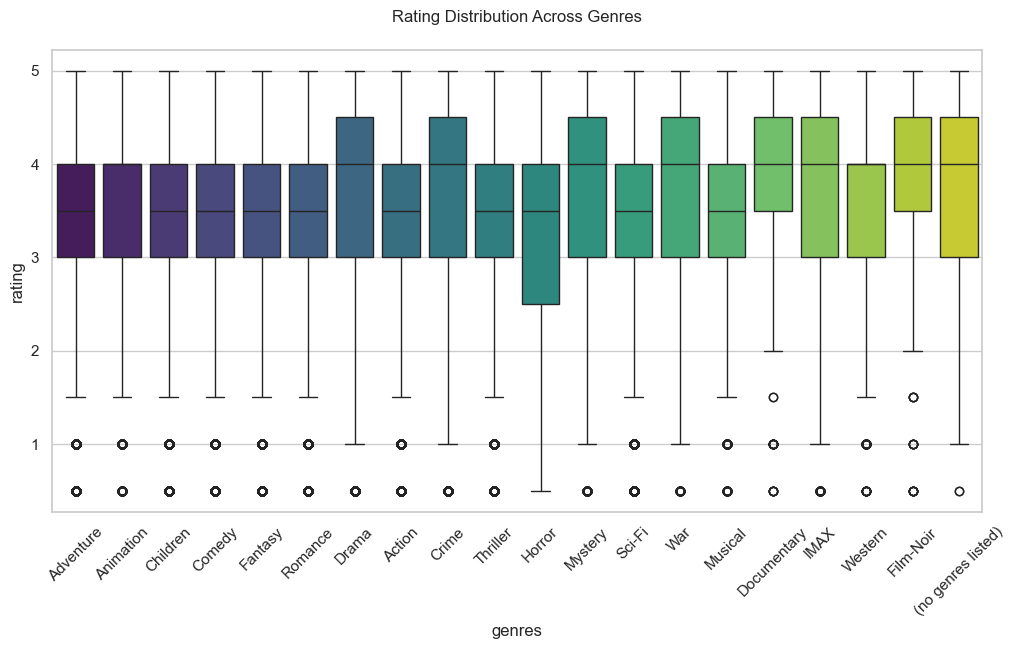

In [138]:
# Rating Distribution by Genre 
df_exploded =df.assign(genres=df['genres'].str.split('|')).explode('genres')

plt.figure(figsize=(12,6))
sns.boxplot(x='genres', y='rating', data=df_exploded, palette='viridis')
plt.title('Rating Distribution Across Genres', pad=20)
plt.xticks(rotation=45)
plt.show()

##### Number of ratings per movie

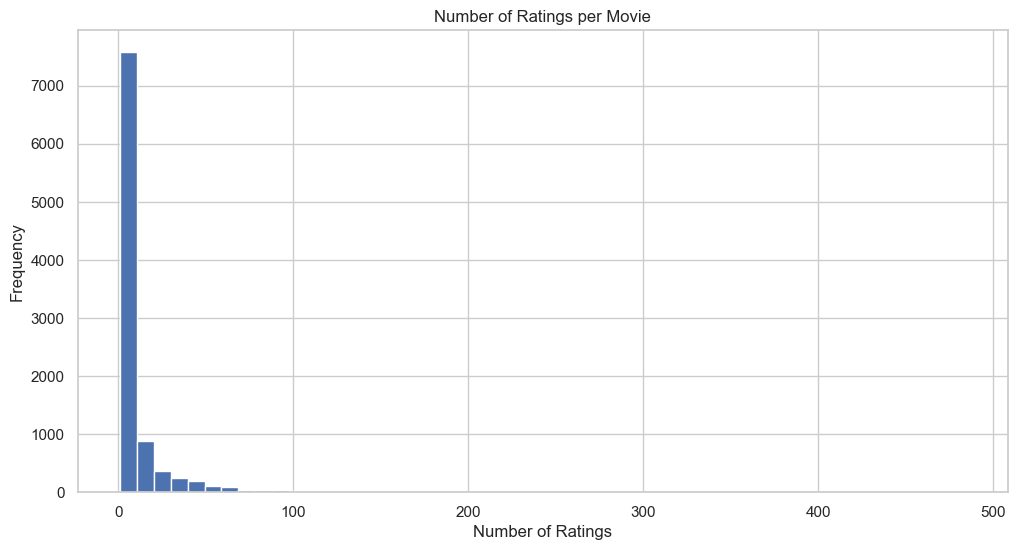

In [139]:
# Number of ratings per movie
ratings_per_movie = df.groupby('movieId')['rating'].count().reset_index()
plt.figure(figsize=(12, 6))
plt.hist(ratings_per_movie['rating'], bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

##### Number of ratings over time

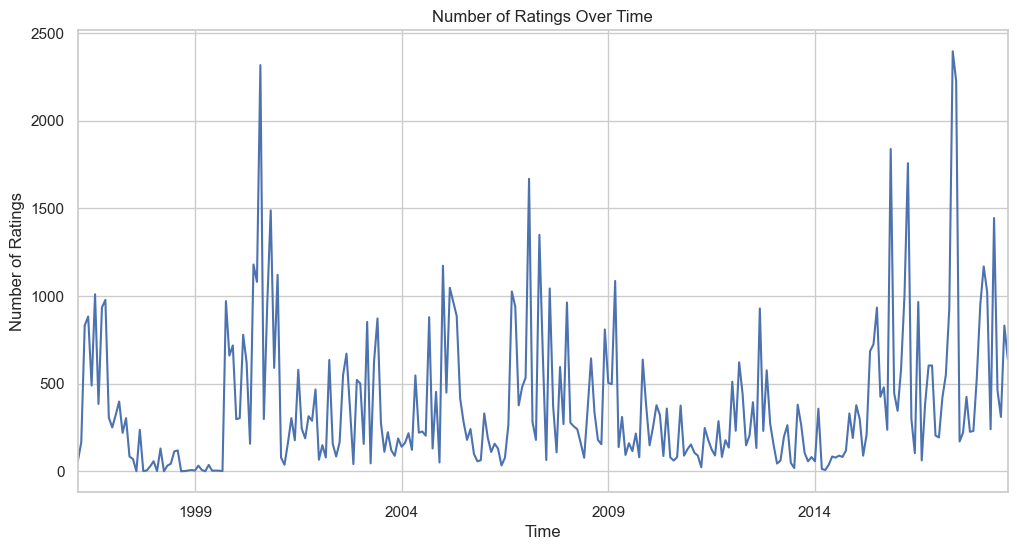

In [140]:
df['timestamp_rating'] = pd.to_datetime(df['timestamp_rating'], unit='s')
# Plot the number of ratings over time (monthly)
plt.figure(figsize=(12, 6))
df.set_index('timestamp_rating').resample('M').size().plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

In [141]:
# average rating for the top 20 rated movies
avg_highly_rated_movies =df.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()
avg_highly_rated_movies.head(20)

,rating
title,
Goodbye Charlie (1964),5.0
"Valet, The (La doublure) (2006)",5.0
Alien Contamination (1980),5.0
Wonder Woman (2009),5.0
Red Sorghum (Hong gao liang) (1987),5.0
Nasu: Summer in Andalusia (2003),5.0
National Lampoon's Bag Boy (2007),5.0
Lesson Faust (1994),5.0
Reform School Girls (1986),5.0


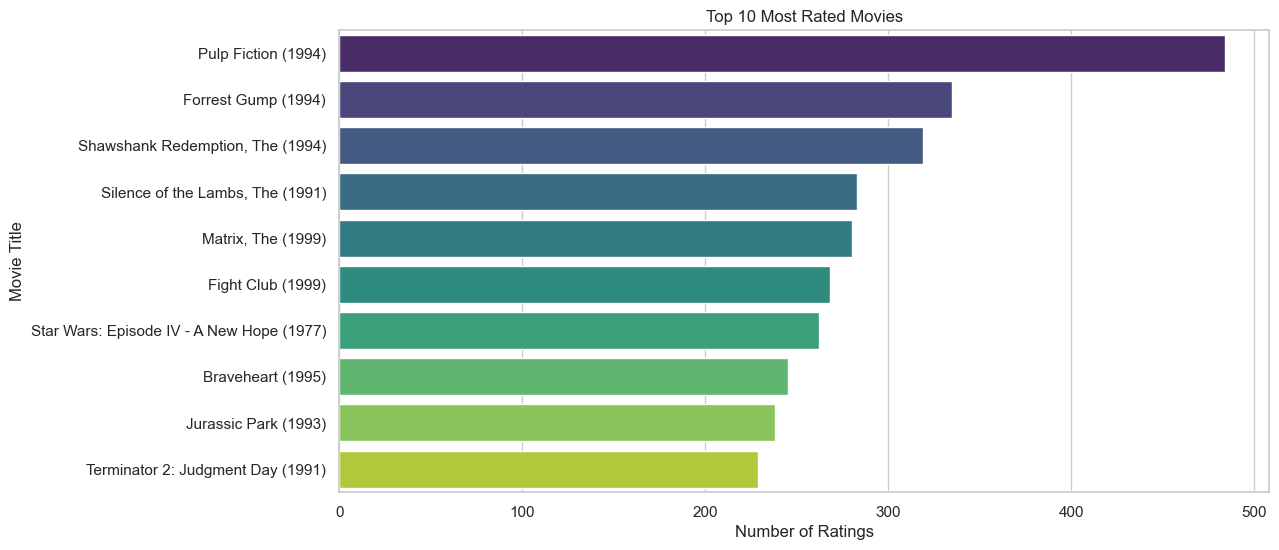

In [142]:
#top 10 most rated movies.
top_rated_movies = df.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
top_rated_movies = pd.merge(top_rated_movies, df[['movieId', 'title']], on='movieId', how='left')
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='title', data=top_rated_movies, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

#### Movies counts in each genre

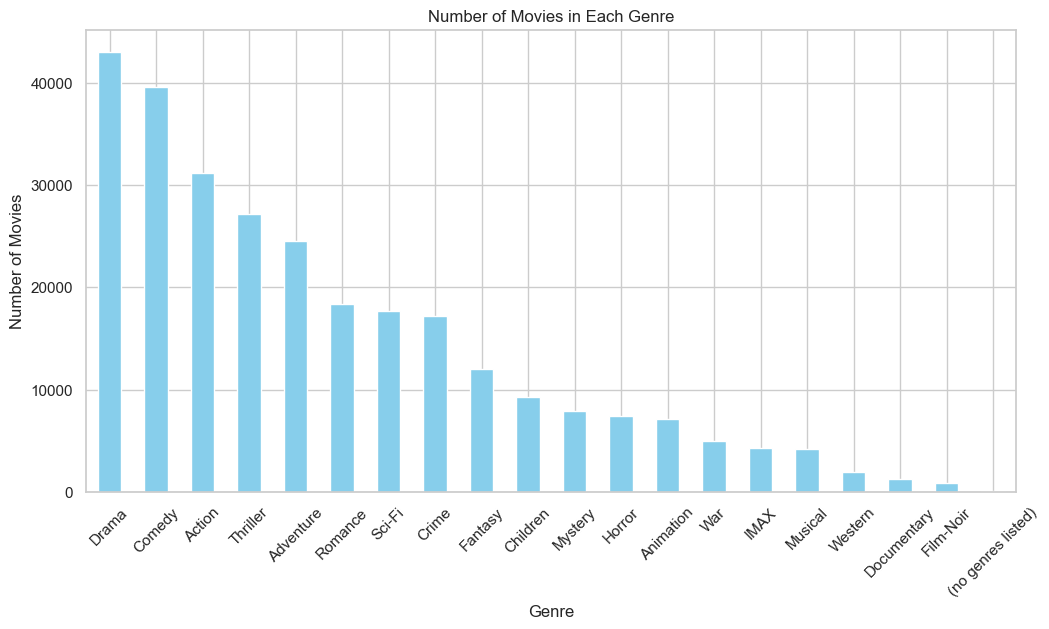

In [143]:
# count of movies in each genre
genre_counts = df['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

### MODELLING

In this project, we will build and evaluate multiple recommender system models using the MovieLens dataset to explore different approaches for providing personalized movie recommendations. The models to be implemented include:
1. Content-Based Filtering 
- TF-IDF (Term Frequency-Inverse Document Frequency)
2. Collaborative Filtering
- Memory-Based (Neighborhood) Approach
- Model-Based (Matrix Factorization) Approach
   - Singular Value Decomposition (SVD)
   

#### Content-Based Filtering
 In the context of the MovieLens dataset, a content-based recommendation system suggests movies that are similar in content to those a user has previously liked. This approach relies on the attributes of the movies themselves, rather than on the preferences of other users.

For this project, we will use movie genres as the primary feature to build the content profiles. By analyzing the genre information, we can compute the similarity between movies and recommend titles that share similar characteristics with the ones a user has rated positively.

The key techniques used in this approach will include:

TF-IDF vectorization to numerically represent movie genres.

In [144]:
# genres in the dataframe
df["genres"]

0         Adventure|Animation|Children|Comedy|Fantasy
1         Adventure|Animation|Children|Comedy|Fantasy
2         Adventure|Animation|Children|Comedy|Fantasy
3         Adventure|Animation|Children|Comedy|Fantasy
4         Adventure|Animation|Children|Comedy|Fantasy
                             ...                     
102690                Action|Animation|Comedy|Fantasy
102691                       Animation|Comedy|Fantasy
102692                                          Drama
102693                               Action|Animation
102694                                         Comedy
Name: genres, Length: 102664, dtype: object

In [145]:
df.shape

(102664, 10)

After merging the movies dataset with the ratings and tags, the number of records significantly increased from 9,742 unique movies to over 100,000 rows hence the unnecessary computational overhead for content-based filtering, which only requires one row per movie. 
To address this, we'll use the dataset without the ratings and tags, stored in the variable df_merged_movie_links. This dataset maintains one row per movie and includes essential metadata (e.g., title, genres, and TMDb IDs), making it better suited for efficient content-based recommendation modeling.

In [146]:
# Merge movies and links on 'movieId'
df_merged_movie_links = pd.merge(movies, links, on='movieId', how='inner')

# Check the result
df_merged_movie_links .head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [147]:
df_merged_movie_links .columns

Index(['movieId', 'title', 'genres', 'imdbId', 'tmdbId'], dtype='object')

In [148]:
df_merged_movie_links.shape

(9742, 5)

In [149]:
# Initialize TF-IDF Vectorizer
tfv = TfidfVectorizer(
    min_df=3,
    max_features=None,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    stop_words='english'
)

df_merged_movie_links ['genres'] = df_merged_movie_links ['genres'].fillna('')
df_merged_movie_links ['genres'] = df_merged_movie_links ['genres'].map(lambda x: ", ".join(x.split("|")))

# Check the first few rows of the 'genres' column
df_merged_movie_links ['genres'].head()



0    Adventure, Animation, Children, Comedy, Fantasy
1                       Adventure, Children, Fantasy
2                                    Comedy, Romance
3                             Comedy, Drama, Romance
4                                             Comedy
Name: genres, dtype: object

In [150]:
tfv_matrix = tfv.fit_transform(df_merged_movie_links['genres'])
tfv_matrix

<9742x23 sparse matrix of type '<class 'numpy.float64'>'
	with 23185 stored elements in Compressed Sparse Row format>

In [151]:
# Computing the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [152]:
num_rows = df_merged_movie_links .shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 9742


we create a reverse mapping of movie titles to their corresponding DataFrame indices. This allows us to quickly retrieve a movie’s position in the dataset 

In [153]:
# reverse mapping of indices and movie titles
indices = pd.Series(df_merged_movie_links.index, index=df_merged_movie_links['title']).drop_duplicates()
indices

title
Toy Story (1995)                                0
Jumanji (1995)                                  1
Grumpier Old Men (1995)                         2
Waiting to Exhale (1995)                        3
Father of the Bride Part II (1995)              4
                                             ... 
Black Butler: Book of the Atlantic (2017)    9737
No Game No Life: Zero (2017)                 9738
Flint (2017)                                 9739
Bungo Stray Dogs: Dead Apple (2018)          9740
Andrew Dice Clay: Dice Rules (1991)          9741
Length: 9742, dtype: int64

In [154]:
# test
indices['Jumanji (1995)']

1

In [155]:
indices['Flint (2017)']


9739

In [156]:
def get_title(text, df=df):
    """Gets movie title matching `text`
    returns:
        title - title of movie matching the input
        genres - the movie's genres 
    """
    mask = df['title'].str.contains(text, case=False, regex=False)
    title = df.loc[mask, 'title'].head(1).values[0] if any(mask) else None
    
    if not title:
        print(f"\n'{text}' does not match any movies. Please try again")
        return None, None

    return title, df.loc[mask].head(1)["genres"].values[0]

In [157]:
# test
print(get_title("Superman (1978)", df))
print()
print(get_title("Game of Thrones", df))

('Superman (1978)', 'Action|Adventure|Sci-Fi')


'Game of Thrones' does not match any movies. Please try again
(None, None)


In [158]:
def give_rec(title, sig=sig):
    """Get the index corresponding to title"""
    try:
        # get title
        title, genres = get_title(title, df_merged_movie_links)
        
        # print the movie title matching the text
        if title:
            print(f"Recommendation for {title}")
            print("Genres: ", genres)
        
        idx = indices[title]
        
        # Get the pairwsie similarity scores 
        sig_scores = list(enumerate(sig[idx]))

        # Sort the movies 
        sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

        # Scores of the 10 most similar movies
        sig_scores = sig_scores[1:11]

        # Movie indices
        movie_indices = [i[0] for i in sig_scores]

        # Top 10 most similar movies
        return df_merged_movie_links.iloc[movie_indices].drop_duplicates()
    except Exception as _:
        print(_)
        return "⚠ Oops! Something went wrong!"
    
    
    
# test
give_rec('Jumanji (1995)')

Recommendation for Jumanji (1995)
Genres:  Adventure, Children, Fantasy


,movieId,title,genres,imdbId,tmdbId
53,60,"Indian in the Cupboard, The (1995)","Adventure, Children, Fantasy",113419,11359.0
109,126,"NeverEnding Story III, The (1994)","Adventure, Children, Fantasy",110647,27793.0
767,1009,Escape to Witch Mountain (1975),"Adventure, Children, Fantasy",72951,14821.0
1514,2043,Darby O'Gill and the Little People (1959),"Adventure, Children, Fantasy",52722,18887.0
1556,2093,Return to Oz (1985),"Adventure, Children, Fantasy",89908,13155.0
1617,2161,"NeverEnding Story, The (1984)","Adventure, Children, Fantasy",88323,34584.0
1618,2162,"NeverEnding Story II: The Next Chapter, The (1...","Adventure, Children, Fantasy",100240,34636.0
1799,2399,Santa Claus: The Movie (1985),"Adventure, Children, Fantasy",89961,13764.0
3574,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"Adventure, Children, Fantasy",241527,671.0
6075,41566,"Chronicles of Narnia: The Lion, the Witch and ...","Adventure, Children, Fantasy",363771,411.0


In [159]:
give_rec("Grumpier Old Men (1995)")

Recommendation for Grumpier Old Men (1995)
Genres:  Comedy, Romance


,movieId,title,genres,imdbId,tmdbId
6,7,Sabrina (1995),"Comedy, Romance",114319,11860.0
35,39,Clueless (1995),"Comedy, Romance",112697,9603.0
57,64,Two if by Sea (1996),"Comedy, Romance",118002,19760.0
60,68,French Twist (Gazon maudit) (1995),"Comedy, Romance",113149,4482.0
103,118,If Lucy Fell (1996),"Comedy, Romance",116606,10324.0
106,122,Boomerang (1992),"Comedy, Romance",103859,11066.0
111,129,Pie in the Sky (1996),"Comedy, Romance",114131,110972.0
152,180,Mallrats (1995),"Comedy, Romance",113749,2293.0
157,186,Nine Months (1995),"Comedy, Romance",113986,11472.0
203,237,Forget Paris (1995),"Comedy, Romance",113097,10525.0


#### Observations
- Since we’re not using ratings or tags, the model reflects only movie content similarity, not popularity or user preferences.
- It only recommends by genre, which is shallow and insufficient, as it doesn't scoop out the patterns deeply embedded in our dataset.
- When using TF-IDF on movie genres, the recommendation system can become rigid, meaning that if a movie is categorized under the genres Action, Adventure, and Sci-Fi, the system will primarily recommend movies that share the exact same combination of genres. This limits flexibility, as it doesn't allow for recommendations based on similar themes or overlapping genres.

### Collaborative Filtering 
 Can be either user-based or item-based:

User-based collaborative filtering recommends items by identifying users with similar preferences and suggesting items they have liked.

Item-based collaborative filtering recommends items that are similar to those the user has already liked, based on the preferences of other users.

#### Memory/ Neighbourhood based:
For this, we first create a pivot table, from which we'll derive our sparse matrix:

In [160]:
#Pivot table
knnrc_df=df.pivot_table(index='title',columns='userId',values='rating').fillna(0)
knnrc_df.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
movie_features_df_matrix = csr_matrix(knnrc_df.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [162]:
# reverse map using the pivot matrix
new_indices = {value: index for index, value in enumerate(knnrc_df.index)}

In [163]:
# test
query_index = new_indices['NeverEnding Story, The (1984)']
distances, indices = model_knn.kneighbors(knnrc_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)


for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(knnrc_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, knnrc_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for NeverEnding Story, The (1984):

1: Willow (1988), with distance of 0.39815826814421695:
2: Honey, I Shrunk the Kids (1989), with distance of 0.4819248973638218:
3: RoboCop (1987), with distance of 0.5002362983443989:
4: Goonies, The (1985), with distance of 0.5004801550132574:
5: Gremlins (1984), with distance of 0.5024165448355301:


#### Model Validation

In [164]:
reader = Reader(rating_scale=(1, 5))

expected_column_names = ["userId", "movieId", "rating"]

# Load the data into a Surprise Dataset
data_surp = Dataset.load_from_df(df[expected_column_names], reader)

In [165]:
 #cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data_surp, n_jobs=-1)


# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_surp)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [166]:
# validation results
for i in cv_knn_baseline.items():
    print(i)
    
print('-----------------------')

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87379886, 0.87916599, 0.86702376, 0.87155276, 0.87445635]))
('test_mae', array([0.66328797, 0.66705713, 0.65932752, 0.66511801, 0.66498114]))
('fit_time', (0.7280111312866211, 0.7839004993438721, 0.9381544589996338, 0.8325395584106445, 0.8013880252838135))
('test_time', (1.2882778644561768, 1.2422330379486084, 1.3341290950775146, 1.3394029140472412, 1.3465330600738525))
-----------------------


0.8731995423819287

In [167]:
# average RMSE score for the test set
for i in cv_knn_basic.items():
    print(i)
# print validation results
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.96647806, 0.9650293 , 0.96199157, 0.96258684, 0.97134889]))
('test_mae', array([0.74428794, 0.74013095, 0.74231398, 0.74081234, 0.74473216]))
('fit_time', (1.3791513442993164, 1.4655706882476807, 1.4670069217681885, 1.4733316898345947, 1.5557827949523926))
('test_time', (2.5298900604248047, 2.5073721408843994, 2.4169211387634277, 2.3268282413482666, 2.1821348667144775))
-----------------------
0.9654869324376314


The KNNBaseline model achieved a lower RMSE of approximately 0.872, indicating that its predictions were closer to the actual ratings compared to the average model, which had an RMSE of about 0.966.

In [179]:

def surp_knn_get_rec(uid, rec_count=10):

    reader = Reader(rating_scale=(1, 5))
    data_ = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, _ = train_test_split(data_, test_size=0.2, random_state=42)
    
    # Train the KNN model
    sim_options = {'name': 'pearson', 'user_based': True}
    knn_model = KNNBasic(sim_options=sim_options)
    knn_model.fit(trainset)

    # Get the user's unrated items
    unrated_items = [item for item in trainset.all_items() if item not in trainset.ur[uid]]

    # Predict ratings for unrated items
    predictions = [knn_model.predict(uid, iid) for iid in unrated_items]

    # Sort the predictions by estimated rating in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # top N recommended items
    top_recommendations = sorted_predictions[:rec_count]

    # Printing the recommended items
    recommended_movie_ids = [prediction.iid for prediction in top_recommendations]
    movie_df = df[['movieId', 'title']]
    recommended_movies = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]

    return recommended_movies
# test
surp_knn_get_rec(uid=150, rec_count=10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,movieId,title
2639,53,Lamerica (1994)
2640,53,Lamerica (1994)
3218,99,Heidi Fleiss: Hollywood Madam (1995)
3219,99,Heidi Fleiss: Hollywood Madam (1995)
4091,148,"Awfully Big Adventure, An (1995)"
5865,213,Burnt by the Sun (Utomlyonnye solntsem) (1994)
5866,213,Burnt by the Sun (Utomlyonnye solntsem) (1994)
5867,213,Burnt by the Sun (Utomlyonnye solntsem) (1994)
5868,213,Burnt by the Sun (Utomlyonnye solntsem) (1994)
5869,213,Burnt by the Sun (Utomlyonnye solntsem) (1994)


The above returns a DataFrame that includes the top 10 recommended movies for the user 150

In [169]:
# test 2
surp_knn_get_rec(uid=300, rec_count=5)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,movieId,title
2639,53,Lamerica (1994)
2640,53,Lamerica (1994)
3842,123,Chungking Express (Chung Hing sam lam) (1994)
3843,123,Chungking Express (Chung Hing sam lam) (1994)
3844,123,Chungking Express (Chung Hing sam lam) (1994)
3845,123,Chungking Express (Chung Hing sam lam) (1994)
7567,283,New Jersey Drive (1995)
7568,283,New Jersey Drive (1995)
7569,283,New Jersey Drive (1995)
15144,549,Thirty-Two Short Films About Glenn Gould (1993)


The function above will return a DataFrame containing the top 5 recommended movies for user 300. This DataFrame will include movie IDs and their corresponding titles.

### Model-Based Methods - Matrix Factorization using SVD:

In [170]:
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=5)

gs_model.fit(data_surp)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.7s finished


Getting the best hyperparameters from grid search

In [176]:
#Hyperparameter tuning

best_params = gs_model.best_params["rmse"]

In [177]:
trainset, testset = train_test_split(data_surp, test_size=0.2)

svd = SVD(**best_params)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8874
0.8873910594076168


0.8883 RMSE suggests that the SVD model is performing reasonably well, with predictions that are fairly close to the actual ratings given by users.In recommender systems, RMSE values typically range from 0.5 to 1.5 in many cases,therefore, an RMSE of 0.8883 can be considered good

In [173]:
# test
svd.predict(uid="250", iid=23)

Prediction(uid='250', iid=23, r_ui=None, est=3.344124780381163, details={'was_impossible': False})

In [174]:

reader = Reader(rating_scale=(1, 5))
data_surp = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

def svd_get_rec(uid=1000, rec_count=10):
    """Returns top N movies using SVD"""
    trainset, testset = train_test_split(data_surp, test_size=0.2)
    
    # Train the SVD model
    svd = SVD()
    svd.fit(trainset)
    
    #  user's unrated items
    unrated_items = [item for item in trainset.all_items() if item not in trainset.ur[uid]]
    
    # Predict ratings for unrated items
    predictions = [svd.predict(uid, iid) for iid in unrated_items]
    
    # Sort the predictions by estimated rating in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    
    #  top N recommended items
    top_recommendations = sorted_predictions[:rec_count]
    
    # Print the recommended items
    recommended_movie_ids = [prediction.iid for prediction in top_recommendations]
    movie_df = df[['movieId', 'title']]  
    recommended_movies = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies

# Test
svd_get_rec(uid=100, rec_count=10)


,movieId,title
8933,318,"Shawshank Redemption, The (1994)"
8934,318,"Shawshank Redemption, The (1994)"
8935,318,"Shawshank Redemption, The (1994)"
8936,318,"Shawshank Redemption, The (1994)"
8937,318,"Shawshank Redemption, The (1994)"
...,...,...
59283,3949,Requiem for a Dream (2000)
59284,3949,Requiem for a Dream (2000)
59285,3949,Requiem for a Dream (2000)
59286,3949,Requiem for a Dream (2000)


In [178]:

reader = Reader(rating_scale=(1, 5))
data_surp = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

def precision_at_k(k=10, threshold=4.0):
    """Compute average Precision@K across all users"""

    # Split data and train SVD
    trainset, testset = train_test_split(data_surp, test_size=0.2, random_state=42)
    algo = SVD()
    algo.fit(trainset)

    # Organize testset ratings by user
    user_test_ratings = defaultdict(list)
    for uid, iid, true_r in testset:
        user_test_ratings[uid].append((iid, true_r))

    precisions = []

    for uid in user_test_ratings:
        try:
            seen_items_inner = trainset.ur[trainset.to_inner_uid(uid)]
            seen_items = set(trainset.to_raw_iid(inner_iid) for (inner_iid, _) in seen_items_inner)
        except ValueError:
            continue  # User not in training set

        all_items = set(df['movieId'].unique())
        unseen_items = all_items - seen_items

        # Predict ratings for unseen items
        predictions = [algo.predict(uid, iid) for iid in unseen_items]
        predictions.sort(key=lambda x: x.est, reverse=True)

        # Top-K recommendations
        top_k_preds = predictions[:k]
        top_k_iids = set(pred.iid for pred in top_k_preds)

        # Relevant items in the test set
        relevant_items = set(iid for iid, rating in user_test_ratings[uid] if rating >= threshold)

        # Precision calculation
        true_positives = top_k_iids & relevant_items
        precision = len(true_positives) / k
        precisions.append(precision)

    if precisions:
        avg_precision = sum(precisions) / len(precisions)
    else:
        avg_precision = 0.0

    print(f'✅ Average Precision@{k}: {avg_precision:.4f}')
    return avg_precision

precision_at_k(k=10, threshold=4.0)


✅ Average Precision@10: 0.0490


0.04901639344262296

Precision@10 = 0.0556
The SVD model recommends, on average, 0.55 relevant items out of 10, which is relatively low.

#### Conclusion

In developing our movie recommender system, we evaluated several recommendation strategies, including content-based filtering, neighborhood-based collaborative filtering (KNN), and model-based collaborative filtering (SVD). Each approach offered distinct advantages and came with its own set of limitations.

Content-Based Filtering
We implemented a content-based recommender using features such as movie genres. This approach successfully recommended movies with similar characteristics, making it useful for users with well-defined preferences. However, it struggled to capture the broader and more diverse interests that users may have beyond surface-level features.

Neighborhood-Based Collaborative Filtering (KNN)
Our neighborhood-based model, built with the KNN algorithm from SciKit-Learn, leveraged user-item interaction data to identify patterns in user behavior. The item-based variant, using cosine similarity, was particularly effective at recommending movies based on similarity in user ratings. This method performed well in identifying similar movies and delivered consistent recommendations.

Model-Based Collaborative Filtering (SVD)
Using the Surprise library, we implemented Singular Value Decomposition (SVD) to uncover latent factors within the user-item matrix. While this model-based approach achieved a respectable RMSE of 0.8925, its performance can be sensitive to hyperparameter tuning and data sparsity.
tions.ing.

#### Recommendation

After evaluating the strengths and limitations of each approach, we propose implementing a hybrid recommendation model that combines the advantages of content-based filtering and collaborative filtering. This integrated strategy enables the system to harness the nuanced user-item interaction patterns identified by collaborative methods while also utilizing content attributes such as genres and metadata to enhance personalization and broaden recommendation diversity.

To further improve the effectiveness of collaborative filtering techniques, especially matrix factorization methods like SVD, additional hyperparameter optimization and scalability testing on larger datasets are recommended. 

In summary, the optimal recommender system depends on factors such as user behavior, application goals, and data characteristics. A well-designed hybrid model, regularly tuned and updated, offers a flexible and high-performing solution for delivering relevant and engaging movie recommendations.